# ECG classification

Laurent Cetinsoy - Datadidacte


In [1]:
from IPython.display import HTML

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scipy.stats import entropy

2025-01-08 23:09:27.884557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## A first naive model by extracting simple features


Your environment contains variables arr, nsr, and chf which respectively contain 10-second recordings of ECG signals extracted from three datasets on PhysioNet: one from a person suffering from arrhythmia, one from a person with a normal heart rhythm, and another from a person with heart failure.


Matplotlib  subplots (or any other library), display these signals on three subfigures (the subplots should be called with the parameter nrows = 3).
Can you find any differences between them?

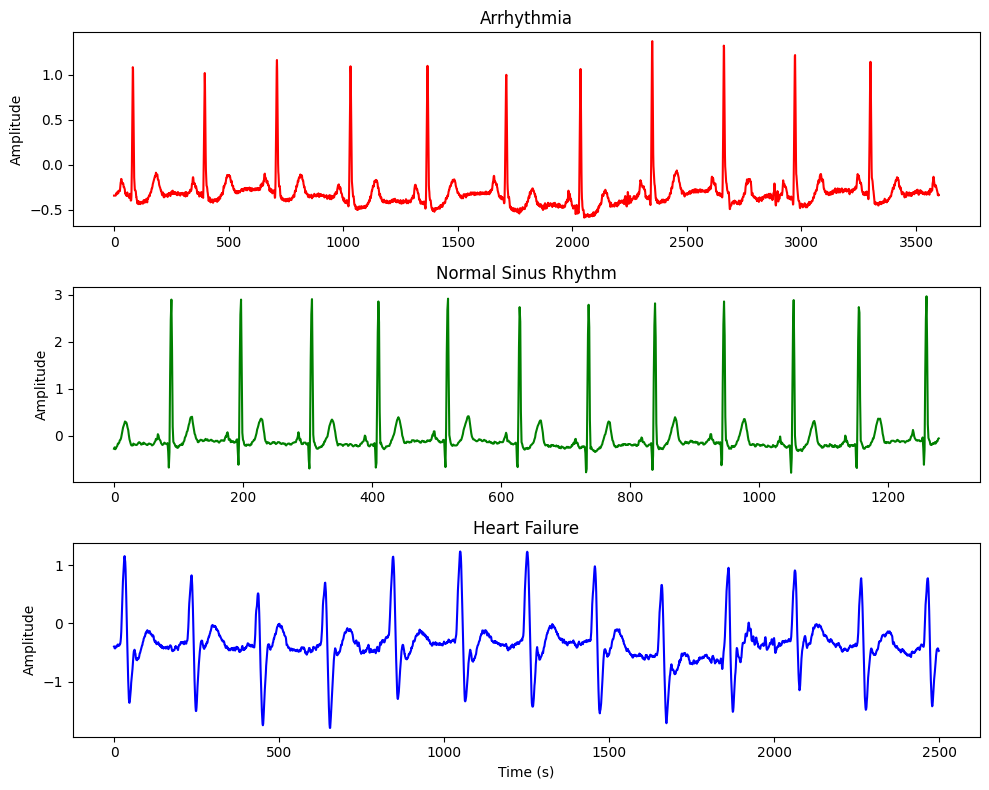

In [3]:
arr = np.loadtxt('arr.txt')
chf = np.loadtxt('chf.txt')
nsr = np.loadtxt('nsr.txt')

# Plotting the ECG signals
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# arr
axs[0].plot(arr, color='r')
axs[0].set_title('Arrhythmia')
axs[0].set_ylabel('Amplitude')

#nsr
axs[1].plot(nsr, color='g')
axs[1].set_title('Normal Sinus Rhythm')
axs[1].set_ylabel('Amplitude')

# chf
axs[2].plot(chf, color='b')
axs[2].set_title('Heart Failure')
axs[2].set_ylabel('Amplitude')
axs[2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

We want to extract features from the time series. For that we will use simple statistics.


Create a function named calculate_stats_features(x) that calculates some statistical features of a signal x using standard numpy functions: nanpercentile, nanmean, etc.
calculate_stats_features will return a list of features in this order:

0. Max
1. Min
2. Mean
3. Median
4. Variance

In [4]:
# Function to calculate statistical features
def calculate_stats_features(x):
    return [
        np.nanmax(x),        # Max
        np.nanmin(x),        # Min
        np.nanmean(x),       # Mean
        np.nanmedian(x),     # Median
        np.nanvar(x)         # Variance
    ]



# Calculate features for each signal
features_arr = calculate_stats_features(arr)
features_nsr = calculate_stats_features(nsr)
features_chf = calculate_stats_features(chf)

print("arr:", features_arr)
print("nsr:", features_nsr)
print("chf:", features_chf)


arr: [1.375, -0.59, -0.3120111111111112, -0.335, 0.039663552654320984]
nsr: [2.965, -0.785, -0.035453124999999995, -0.145, 0.21755463842773434]
chf: [1.235, -1.79, -0.363622, -0.375, 0.15541165111599997]




Create a function named `calculate_zero_crossing(x)` that calculates the Zero
Crossing of a signal x.

The zero crossing is defined as the number of times the signal changes sign.
For this, you can use the signbit, diff, and nonzero functions from numpy.


In [5]:

def calculate_zero_crossing(x):
    sign_x = np.sign(x)
    sign_diff = np.diff(sign_x)
    zero_crossings = np.count_nonzero(sign_diff)
    
    return zero_crossings


Create a function named **calculate_rms(x)** that returns the Root Mean Square (RMS) of a signal x. We will use the nanmean function instead of the mean function from numpy.

In [6]:

def calculate_rms(x):
    squared_x = np.square(x)
    mean_squared = np.nanmean(squared_x)
    rms = np.sqrt(mean_squared)
    return rms


Create a function named calculate_entropy(x) that calculates the Shannon entropy of a signal x using the entropy function from scipy.stats.

In [7]:

def calculate_entropy(x):
    v, c = np.unique(x, return_counts=True)
    p = c/len(x)    
    return  entropy(p)


Create a function get_features(x) that combines the features calculated by all previous functions including caculate_stats_features.

In [8]:
def get_features(x):
    # Calculate each feature
    stats_features = calculate_stats_features(x)
    zero_crossings = calculate_zero_crossing(x)
    rms = calculate_rms(x)
    entropy_val = calculate_entropy(x)
    
    # Put in one list
    features = stats_features + [zero_crossings, rms, entropy_val]
    
    return features

Load the small ecg dataset
Use your fonction get_features create a new dataframe where you have all the feature as X and y as the label.
Train a random forest on it after doing a train test split if the dataset is not too small

In [9]:
# Load dataset
df = pd.read_csv('ecg_small_dataset.csv')
X, y = [], []

# process data
for _, row in df.iterrows():
    ts = row[2:].values  
    lbl = row[1]  
    X.append(get_features(ts))
    y.append(lbl)

# df
X = pd.DataFrame(X, columns=['Max', 'Min', 'Mean', 'Med', 'Var', 'ZC', 'RMS', 'Ent'])
y = pd.Series(y, name='Lbl')

# Train and test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# Train 
clf = RandomForestClassifier(random_state=42)
clf.fit(X_tr, y_tr)

# Pred
y_te_pred = clf.predict(X_te)

# Result
print("Result:")
print(classification_report(y_te, y_te_pred))

Result:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/tmp/ipykernel_33831/3954723016.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lbl = row[1]
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/ep

Now you have a first pipeline, do the same on the full dataset
Report the train and test loss

In [10]:
# Load dataset
df = pd.read_csv('ECG-laurent.csv')
X, y = [], []

# process data
for _, row in df.iterrows():
    ts = row[2:].values  
    lbl = row[1]  
    X.append(get_features(ts))
    y.append(lbl)

# df
X = pd.DataFrame(X, columns=['Max', 'Min', 'Mean', 'Median', 'Variance', 'ZeroCrossings', 'RMS', 'Entropy'])
y = pd.Series(y, name='Lbl')

# Train and test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# Train 
clf = RandomForestClassifier(random_state=42)
clf.fit(X_tr, y_tr)

# Pred
y_te_pred = clf.predict(X_te)

# Result
print("Result:")
print(classification_report(y_te, y_te_pred))

/tmp/ipykernel_33831/997142380.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ECG-laurent.csv')
/tmp/ipykernel_33831/997142380.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lbl = row[1]


Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.76      0.97      0.85        29
           2       0.50      0.10      0.17        10

    accuracy                           0.80        49
   macro avg       0.75      0.69      0.67        49
weighted avg       0.75      0.80      0.74        49



try to tweak the model hyperparameter to see if it works

In [11]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 10, 20],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required to be at a leaf node
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=0)

grid_search.fit(X_tr, y_tr)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_

print("Best parameters: ", best_params)

y_test_pred = best_clf.predict(X_te)

print("\nResult with best modell:")
print(classification_report(y_te, y_test_pred))

Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}

Result with best modell:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.80      0.97      0.88        29
           2       0.75      0.30      0.43        10

    accuracy                           0.84        49
   macro avg       0.85      0.76      0.77        49
weighted avg       0.83      0.84      0.81        49



## Fourier transform features

We want now to see if a model using only fourier transform could work.

create a function get_fourier_coefficients(ecg)

In [12]:
def get_fourier_coefficients(ecg, n_coefficients=10):
    fft_result = np.fft.fft(ecg)
    fft_magnitude = np.abs(fft_result)
    fft_coefficients = fft_magnitude[1:n_coefficients+1]
    return fft_coefficients.tolist()


Using this function create a dataframe df_fourrier containing the fourrier transform coefficients and the label

In [13]:
fourier_features_list = []
labels = []

for index, row in df.iterrows():
    time_series = row[2:].values 
    label = row[1] 
    fourier_features = get_fourier_coefficients(time_series)
    fourier_features_list.append(fourier_features)
    labels.append(label)

n_coefficients = len(fourier_features_list[0])  
columns = [f'Fourier_Coeff_{i+1}' for i in range(n_coefficients)]

# df
df_fourrier = pd.DataFrame(fourier_features_list, columns=columns)

# Add the label 
df_fourrier['Label'] = labels


print(df_fourrier)


/tmp/ipykernel_33831/259185693.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]


     Fourier_Coeff_1  Fourier_Coeff_2  Fourier_Coeff_3  Fourier_Coeff_4  \
0        1850.171567       295.333800      1185.545859       926.385162   
1        4137.499334      2152.391165      2520.424900      2066.642615   
2         400.463461       481.532272       729.461562       964.923609   
3         313.204866       531.520312       667.082007       647.502832   
4         303.329945       596.020424       609.179346       380.981983   
..               ...              ...              ...              ...   
157       593.412836       760.985169      1294.411838      1341.284484   
158       378.721372       408.463206       581.751509       276.486875   
159      1434.196761      2603.621630       769.678837      1109.373133   
160       289.587563       621.209385       322.026792       332.194610   
161       683.773983      1434.478998      2887.008289       976.316846   

     Fourier_Coeff_5  Fourier_Coeff_6  Fourier_Coeff_7  Fourier_Coeff_8  \
0         538.293366    

Try to train a model using the Fourrier coefficient

In [14]:
# Train-test split
X = df_fourrier.drop(columns=['Label'])
y = df_fourrier['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)

# Train 
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict 
y_test_pred = clf.predict(X_test)

# Result
print("\nResult:")
print(classification_report(y_test, y_test_pred))



Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.77      1.00      0.87        17
           2       0.00      0.00      0.00         5

    accuracy                           0.83        30
   macro avg       0.59      0.67      0.62        30
weighted avg       0.70      0.83      0.76        30



/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Try to learn a model using both fourrier coefficient and the features from the previous sections. Does it work ?

In [15]:

def get_combined_featuresandF(x):
    stats_features = calculate_stats_features(x)
    zero_crossings = calculate_zero_crossing(x)
    rms = calculate_rms(x)
    entropy_val = calculate_entropy(x)
    fourier_features = get_fourier_coefficients(x)
    features = stats_features + [zero_crossings, rms, entropy_val] + fourier_features
    return features


combined_features_list = []
labels = []


for index, row in df.iterrows():
    time_series = row[2:].values 
    label = row[1]  
    

    combined_features = get_combined_featuresandF(time_series)
    

    combined_features_list.append(combined_features)
    labels.append(label)

# Create DataFrame with combined features and labels
n_combined_features = len(combined_features_list[0])
columns = ['Max', 'Min', 'Mean', 'Median', 'Variance', 'ZeroCrossings', 'RMS', 'Entropy'] + \
          [f'Fourier_Coeff_{i+1}' for i in range(len(fourier_features))]

df_combined = pd.DataFrame(combined_features_list, columns=columns)
df_combined['Label'] = labels

# Train-test split
X = df_combined.drop(columns=['Label'])
y = df_combined['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)

# Train
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_test_pred = clf.predict(X_test)

# Result
print("\nResult:")
print(classification_report(y_test, y_test_pred))


/tmp/ipykernel_33831/1085781370.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]



Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.77      1.00      0.87        17
           2       0.00      0.00      0.00         5

    accuracy                           0.83        30
   macro avg       0.59      0.67      0.62        30
weighted avg       0.70      0.83      0.76        30



/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [16]:
#It is not better but it works

## Wavelets

We now wants to use another signal decomposition which are called wavelet. Wavelet are a multi-scale function decomposition on a familly of functions generated from what is called a mother wavelet.

Using PyWavelet make a function get_wavelet_coefficients(ecg) that returns the wavelet coefficient of a given ECG


In [17]:
pip install pywavelets


Note: you may need to restart the kernel to use updated packages.


In [18]:
import pywt


def get_wavelet_coefficients(ecg, wavelet='db4', level=4):
    coeffs = pywt.wavedec(ecg, wavelet, level=level)
    wavelet_coefficients = np.concatenate(coeffs).tolist()
    return wavelet_coefficients

Using the get_wavelet_coefficients, create a dataframe when the features are the coefficients and include the label

In [19]:
wavelet_features_list = []
labels = []

for index, row in df.iterrows():
    time_series = row[2:].values 
    label = row[1] 
    
    wavelet_features = get_wavelet_coefficients(time_series)
    
    wavelet_features_list.append(wavelet_features)
    labels.append(label)

# df
n_coefficients = len(wavelet_features_list[0])
columns = [f'Wavelet_Coeff_{i+1}' for i in range(n_coefficients)]

df_wavelet = pd.DataFrame(wavelet_features_list, columns=columns)

df_wavelet['Label'] = labels

print(df_wavelet)


/tmp/ipykernel_33831/3371426252.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]


     Wavelet_Coeff_1  Wavelet_Coeff_2  Wavelet_Coeff_3  Wavelet_Coeff_4  \
0          -0.228740        -0.190008        -0.179619        -0.226580   
1          -2.284291        -2.311781        -2.299607        -2.283637   
2          -0.821863        -0.796012        -0.774485        -0.775475   
3           0.348926         0.375198         0.371578         0.332356   
4          -1.643063        -1.666765        -1.676780        -1.630421   
..               ...              ...              ...              ...   
157        -1.256411        -1.176086        -1.000601        -1.271352   
158        -1.547153        -1.558670        -1.539930        -1.546184   
159        -0.365921        -0.357162        -0.362281        -0.369334   
160         0.731175         0.785912         0.819470         0.593377   
161         0.690330         0.747722         0.748915         0.634233   

     Wavelet_Coeff_5  Wavelet_Coeff_6  Wavelet_Coeff_7  Wavelet_Coeff_8  \
0          -0.031340    

Train a random forest classifier with such features. DOes the model work

In [20]:
#Split
X = df_wavelet.drop(columns=['Label'])
y = df_wavelet['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)

# Train 
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_test_pred = clf.predict(X_test)

# Result
print("\nResult:")
print(classification_report(y_test, y_test_pred))



Result:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.57      1.00      0.72        17
           2       0.00      0.00      0.00         5

    accuracy                           0.57        30
   macro avg       0.19      0.33      0.24        30
weighted avg       0.32      0.57      0.41        30



/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [21]:
#It works but it is worse

Add one or several of the previous feature functions and try to train another model

In [22]:
def get_combined_features(x):
    stats_features = calculate_stats_features(x)
    wavelet_features = get_wavelet_coefficients(x)
    combined_features = stats_features + wavelet_features
    return combined_features

In [23]:
combined_features_list = []
labels = []

for index, row in df.iterrows():
    time_series = row[2:].values
    label = row[1]  
    
    combined_features = get_combined_features(time_series)
    
    combined_features_list.append(combined_features)
    labels.append(label)

n_wavelet_coefficients = len(get_wavelet_coefficients(time_series)) 
columns = ['Max', 'Min', 'Mean', 'Median', 'Variance'] + [f'Wavelet_Coeff_{i+1}' for i in range(n_wavelet_coefficients)]

df_combined = pd.DataFrame(combined_features_list, columns=columns)
df_combined['Label'] = labels

print(df_combined)


/tmp/ipykernel_33831/3471101090.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]


          Max       Min      Mean    Median  Variance  Wavelet_Coeff_1  \
0    3.006143 -2.460911 -0.268554 -0.346791  0.420271        -0.228740   
1    2.527708 -3.550697 -0.221014 -0.106818  0.536639        -2.284291   
2    2.264555 -3.929179 -0.163022 -0.153941  0.182135        -0.821863   
3    3.055421 -1.906982  0.053962  0.051409  0.158568         0.348926   
4    2.035001 -1.575197 -0.148872 -0.174830  0.111417        -1.643063   
..        ...       ...       ...       ...       ...              ...   
157  0.635837 -2.036593 -0.217742 -0.113975  0.165278        -1.256411   
158  2.777683 -1.408466 -0.270539 -0.258593  0.023627        -1.547153   
159  0.919894 -1.070185 -0.172078 -0.164195  0.018569        -0.365921   
160  7.078177 -5.961910 -0.343730 -0.390100  0.545255         0.731175   
161  4.478441 -4.748514 -0.264106 -0.214821  0.213515         0.690330   

     Wavelet_Coeff_2  Wavelet_Coeff_3  Wavelet_Coeff_4  Wavelet_Coeff_5  ...  \
0          -0.190008        -0.

In [24]:
X = df_combined.drop(columns=['Label'])
y = df_combined['Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)

# Train
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict 
y_test_pred = clf.predict(X_test)

# Result
print("\nResult")
print(classification_report(y_test, y_test_pred))



Result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.59      1.00      0.74        17
           2       1.00      0.20      0.33         5

    accuracy                           0.60        30
   macro avg       0.53      0.40      0.36        30
weighted avg       0.50      0.60      0.47        30



/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Specify the methodology you used to train the model and report the various attempts results into a table

## Deep learning (1D CNN)

Now we want to see if we can skip all theses feature engineering techniques !
Design and train a multi-layer one dimensional CNN using the raw ECG signal as features.


Could you reach or surpass the feature based models ?

In [25]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [26]:
X = df.iloc[:, 2:].values 
y = df.iloc[:, 1].values  

# Normalize dta
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encoding 
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.18, random_state=42)

# Reshape 
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (132, 65536, 1)
Test data shape: (30, 65536, 1)


In [27]:
# Male model
def create_1d_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

# Create the model
model = create_1d_cnn_model(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-08 23:11:05.289414: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536608768 exceeds 10% of free system memory.
2025-01-08 23:11:05.392888: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536608768 exceeds 10% of free system memory.
2025-01-08 23:11:05.447107: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536608768 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 65532, 64)      │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32766, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32762, 128)     │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16381, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16377, 128)     │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8188, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1048064)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   134,152,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,276,227 (512.22 MB)

 Trainable params: 134,276,227 (512.22 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train 
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=2)


Epoch 1/30


2025-01-08 23:11:06.558562: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536608768 exceeds 10% of free system memory.
2025-01-08 23:11:07.203408: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536838144 exceeds 10% of free system memory.


4/4 - 15s - 4s/step - accuracy: 0.4407 - loss: 52.0255 - val_accuracy: 0.5000 - val_loss: 3.1575
Epoch 2/30
4/4 - 13s - 3s/step - accuracy: 0.4068 - loss: 2.3035 - val_accuracy: 0.3571 - val_loss: 1.2781
Epoch 3/30
4/4 - 13s - 3s/step - accuracy: 0.6949 - loss: 0.8412 - val_accuracy: 0.4286 - val_loss: 1.0249
Epoch 4/30
4/4 - 13s - 3s/step - accuracy: 0.8814 - loss: 0.5414 - val_accuracy: 0.5000 - val_loss: 1.2335
Epoch 5/30
4/4 - 14s - 3s/step - accuracy: 0.8559 - loss: 0.3457 - val_accuracy: 0.7143 - val_loss: 0.9949
Epoch 6/30
4/4 - 13s - 3s/step - accuracy: 0.9068 - loss: 0.1944 - val_accuracy: 0.7143 - val_loss: 1.1693
Epoch 7/30
4/4 - 13s - 3s/step - accuracy: 0.9831 - loss: 0.0751 - val_accuracy: 0.7143 - val_loss: 1.4961
Epoch 8/30
4/4 - 13s - 3s/step - accuracy: 0.9831 - loss: 0.0927 - val_accuracy: 0.7143 - val_loss: 1.5022
Epoch 9/30
4/4 - 14s - 3s/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.7143 - val_loss: 1.6846
Epoch 10/30
4/4 - 13s - 3s/step - accuracy: 0.9

In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("\nRes:")
# Ensure target_names is a list of strings
target_names = label_encoder.classes_.astype(str)
print(classification_report(y_test_true, y_test_pred, target_names=target_names))



Test Accuracy: 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step

Res:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.74      1.00      0.85        17
           2       1.00      1.00      1.00         5

    accuracy                           0.80        30
   macro avg       0.91      0.75      0.75        30
weighted avg       0.85      0.80      0.76        30



In [ ]:
#I could not surpass the base feature model